In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

# Transfer Learning for Pneumonia identification in Chest X-rays

![Image from CheXNet](images/CheXNet_X-rays.png)

When you start to learn something new, you do not start as a blank slate, knowing nothing about the world. Instead, you use your existing knowledge to apply that to learning the new information. This is the idea behind transfer learning. Rather than start a model from random states, can we use information from previous training and apply that to the new data/task.

If you took the Nvidia DLI [*Getting started with Deep Learning*](https://courses.nvidia.com/courses/course-v1:DLI+S-FX-01+V1/about) course, there's a fun example used there. They start with the task of making a doggy door that lets dogs in and out of your house, and keeps cats inside. The example uses a pre-trained model. Early on, we talked about the compute and power that go into training some of the larger AI models, so making use of those pre-trained resources is both helpful and environmentally conscious. 

The example continues with a scenario where the Secret Service has learned of your amazing AI-powered doggy door, and contacts you with a request to make a special version for the White House that will only let Bo (President Obama's dog--the example is a bit older) in, but not other dogs. In this example, they use the VGG16 model and transfer learning to recognize Bo vs other dogs. The VGG16 model knows how to distinguish 1,000 categories of things, but can't distinguish Bo from other dogs. Rather than start from scratch, why not make use of the existing knowledge and improve on that?

## Pre-trained models

There are many sources of pre-trained models. Some are built into `tensorflow` and other frameworks, there are model zoos (like [modelzoo.co](https://modelzoo.co/), [Nvidia NGC](https://catalog.ngc.nvidia.com/models), [Hugging Face](https://huggingface.co/models)), and many are posted in GitHub or with the papers that describe them.

You can export your own trained models using: `model.save('filename')`

You can load models from disk with something like: `keras.models.load_model('filename')`

Again, using pre-trained models when you can, not only saves time, but compute resources and energy. 

## Pre-trained models in medical imaging

There has been a fair bit of debate about the best ways to make use of pre-trained models for medical imaging. In many ways, X-rays, CT-scans, skin lesions, etc differ from images of other things out in the world--the things that make up most of the datasets that these models are trained on. Satya Mallick has a great summary of considerations and methods in this article: [Transfer Learning for Medical Images](https://learnopencv.com/transfer-learning-for-medical-images/). In that article, Satya references this review: Morid, Borjali and Fiol. 2021. [A scoping review of transfer learning research on medical image analysis using ImageNet](https://doi.org/10.1016/j.compbiomed.2020.104115). *Computers in Biology and Medicine*. **128:** 104115.

This figure summarizes papers that have used different pre-trained models for various medical imaging tasks.

<figure>
   <img align='center' src='images/Morid_etal_2021_Fig3.png' alt='Figure 3 from Morid et al (2021)'>
   <figcaption halign='center'><strong>Figure 3 from Morid <i>et al</i> (2021):</strong> Frequency of studies using specific types of TL CNN models per image type.</figcaption>
</figure>


## ImageNet

Most of these models are trained on a benchmark set of images know as [ImageNet](https://www.image-net.org/). ![ImageNet logo](https://www.image-net.org/static_files/index_files/logo.jpg)

ImageNet was developed by Fei-Fei Li and her research group and is one of the most important computer vision datasets. The most commonly used dataset has 1,000 image classes, though there are now datasets with [21,000 classes](https://arxiv.org/abs/2104.10972), bounding boxes for objects and additional attributes.

Numerous privacy and ethical concerns have been raised about ImageNet: e.g. [this](https://analyticsindiamag.com/image-datasets-bias-privacy-mit/), [this](https://www.nature.com/articles/s42256-022-00442-2) and [this](https://visualai.princeton.edu/fcvd/assets/Denton_slides.pdf) . Privacy has been somewhat addressed by a blurred faces version of the dataset (see [this](https://venturebeat.com/2021/03/16/imagenet-creators-find-blurring-faces-for-privacy-has-a-minimal-impact-on-accuracy/)).

## Models behave differently on medical images

Some of the conclusions of Morid *et al.* (2021) are:
* Model architectures that perform better on ImageNet don't necessarily perform better on medical images.
  * Interestingly, some of the more complex, newer models perform worse than older models. 
  Satya notes:
  > In other words, the newer architectures may be overfitting to ImageNet, which probably explains the popularity of older architectures in the medical domain. 
* Model family (e.g. DenseNet, VGGNet, ResNet) matters more for a task than size of model within a family (DenseNet 121, 169, 201).
  * Model families are typically named with the number of layers
* Using the model, with pre-trained weights from the ImageNet training is generally best
* While it's common practice (and what we will do) to chop off the last layers, you can sometimes save computational time by truncating the models even more, chopping off whole blocks (we'll see the DenseNet has modular blocks repeated). 
  * I love Satya's term for this:
  > Truncated architectures are DeepCakes, as in you can have your cake and eat it too!




## CheXNet

The example we'll (somewhat) replicate in this exercise is from the paper by Rajpurkar *et al* ([2017: *CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning*](https://arxiv.org/abs/1711.05225)). The last author on this paper is another leader in AI, Andrew Ng. In this paper, they use the DenseNet121 model, with ImageNet weights, to do transfer learning to make a model that can interpret chest X-rays, specifically, identifying those with Pneumonia. The claim, both from the title and this tweet are that the model outperforms radiologists:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Should radiologists be worried about their jobs? Breaking news: We can now diagnose pneumonia from chest X-rays better than radiologists. <a href="https://t.co/CjqbzSqwTx">https://t.co/CjqbzSqwTx</a></p>&mdash; Andrew Ng (@AndrewYNg) <a href="https://twitter.com/AndrewYNg/status/930938692310482944?ref_src=twsrc%5Etfw">November 15, 2017</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


There is an interesting review of the paper by Lauren Oakden-Rayner: [CheXNet: an in-depth review](https://laurenoakdenrayner.com/2018/01/24/chexnet-an-in-depth-review/). I encourage you to check it out!

## What the CheXNet paper describes

From the paper (p. 2):

> ### 2.2. Model Architecture and Training
>
> CheXNet is a 121-layer Dense Convolutional Network (DenseNet) (Huang et al., 2016) trained on the ChestX-ray 14 dataset. DenseNets improve flow of information and gradients through the network, making the optimization of very deep networks tractable. We replace the final fully connected layer with one that has a single output, after which we apply a sigmoid nonlinearity. 
>
> The weights of the network are initialized with weights from a model pretrained on ImageNet (Deng et al., 2009). The network is trained end-to-end using Adam with standard parameters (β1 = 0.9 and β2 = 0.999) (Kingma & Ba, 2014). We train the model using minibatches of size 16. We use an initial learning rate of 0.001 that is decayed by a factor of 10 each time the validation loss plateaus after an epoch, and pick the model with the lowest validation loss. 


## DenseNet

DenseNet was described Huang *et al* [2016: *Densely Connected Convolutional Networks*](https://arxiv.org/abs/1608.06993) in and published as Huang *et al.* [2019](https://doi.org/10.1109/TPAMI.2019.2918284). Here's the abstract of the arxiv paper (my emphasis):
> Recent work has shown that **convolutional networks can be substantially deeper, more accurate, and efficient to train if they contain shorter connections between layers close to the input and those close to the output**. In this paper, we embrace this observation and introduce the Dense Convolutional Network (DenseNet), which **connects each layer to every other layer** in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections - one between each layer and its subsequent layer - our network has L(L+1)/2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. **DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters**. We evaluate our proposed architecture on four highly competitive object recognition benchmark tasks (CIFAR-10, CIFAR-100, SVHN, and ImageNet). DenseNets obtain significant improvements over the state-of-the-art on most of them, whilst requiring less computation to achieve high performance. Code and pre-trained models are available at [this https URL](https://github.com/liuzhuang13/DenseNet).

And the figure describing the architecture:

<figure>
   <img align='center' src='images/Huang_etal_2017_DenseNet.png' alt='Figure 1 from Huang et al (2017)'>
   <figcaption halign='center'><strong>Figure 1 from Huang <i>et al</i> (2017):</strong> A 5-layer dense block with a growth rate of k = 4. Each
layer takes all preceding feature-maps as input.</figcaption>
</figure>

There blocks are then combined to make deeper models:

<figure>
   <img align='center' src='images/Huang_etal_2017_DenseNet_fig2.png' alt='Figure 2 from Huang et al (2017)'>
   <figcaption halign='center'><strong>Figure 2 from Huang <i>et al</i> (2017):</strong>  A deep DenseNet with three dense blocks. The layers between two adjacent blocks are referred to as transition layers and change feature map sizes via convolution and pooling.</figcaption>
</figure>

## Transfer learning steps

### 1. Select a model

Again, DenseNet is one of many possible models, and within the DenseNet family, there are different sized models. For this, we will use the DenseNet121 model.

### 2. Keep weights?

It is possible to use the DenseNet model as a starting point and train that from scratch with our data. Doing this, we benefit from the work that went into designing the model architecture. However, this typically isn't the best approach. Unless we have large training datasets, it's unlikely that we will be as successful, especially with larger, deeper models, as training with millions of images in the commonly used datasets.

For most transfer learning use cases, we keep the model weights that have been learned on a particular dataset. In our case, we will use the weights learned on ImageNet.

### 3. Chop off the final layers

The final layers of DenseNet121 are the classification layers for ImageNet that output probabilities that an input image belongs to one of 1,000 categories. We don't want that, we want a binary classification of Pneumonia, not Pneumonia. It's amazingly easy to do brain surgery on AI models, and chop off the final layers.

### 4. Freeze the model weights

Before we start training, we want to freeze the existing weights (from ImageNet) so that only our new layer we add in the next step are part of the initial training. We will look at optionally unfreezing these weights in fine tuning later.

### 5. Add new layers for the task at hand

To get a binary classification, we know we want a **sigmoid**. The paper again state: "We replace the final fully connected layer with one that has a single output, after which we apply a sigmoid nonlinearity." (Rajpurkar et al 2017). The best I could interpret that was adding a dense layer and a sigmoid. I did find that I needed to flatten before the dense layer. The paper was implemented in PyTorch, and we're using Keras, so it's a bit different in places...

### 6. Train the model

Now that we have our model we can train it using our chest X-ray data.

### 7. Fine Tune the model

As an optional step (one that we'll likely skip), we can unfreeze all the weights and fine tune the model using a low learning rate to increase performance even more.

## Let's get going!

In [2]:
import os
import shutil
import keras
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image as image_utils
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import decode_predictions

from keras.layers import Dense

## The DenseNet121 model

First, let's take a quick look at the DenseNet121 model.

In [3]:
# Load DenseNet121 pre-trained on imagenet.

model = keras.applications.densenet.DenseNet121(
    include_top=True, weights='imagenet')

In [4]:
model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,062,504 (30.76 MB)

 Trainable params: 7,978,856 (30.44 MB)

 Non-trainable params: 83,648 (326.75 KB)

That's a big model!

## Test with an image

Let's look at how the model does with an alligator image.

In [5]:
# Funtions to show the images, load and process them to the correct input shape and make a prediction

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)
    
def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

def densenet_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(1024, 768, 3)


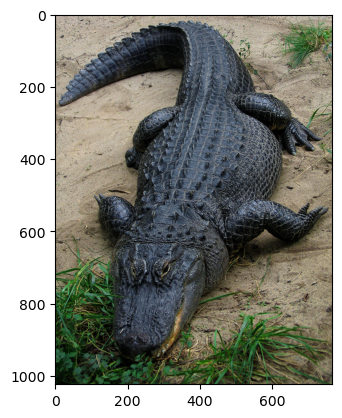

In [6]:
show_image("images/American_Alligator.jpg")

In [7]:
processed_image = load_and_process_image("images/American_Alligator.jpg")

Original image shape:  (1024, 768, 3)
Processed image shape:  (1, 224, 224, 3)


(1024, 768, 3)
Original image shape:  (1024, 768, 3)
Processed image shape:  (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
Predicted: [[('n01698640', 'American_alligator', np.float32(0.9773332)), ('n01697457', 'African_crocodile', np.float32(0.022594044)), ('n01689811', 'alligator_lizard', np.float32(3.1914937e-05))]]


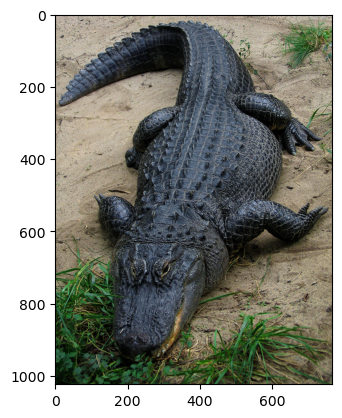

In [8]:
densenet_prediction("images/American_Alligator.jpg")

### How does the model do on Chest X-rays?

Just for fun, let's give it a Chest X-ray and see what it thinks...

(1024, 1024)
Original image shape:  (1024, 1024)
Processed image shape:  (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted: [[('n01990800', 'isopod', np.float32(0.5269986)), ('n01768244', 'trilobite', np.float32(0.12394522)), ('n01491361', 'tiger_shark', np.float32(0.0452976))]]


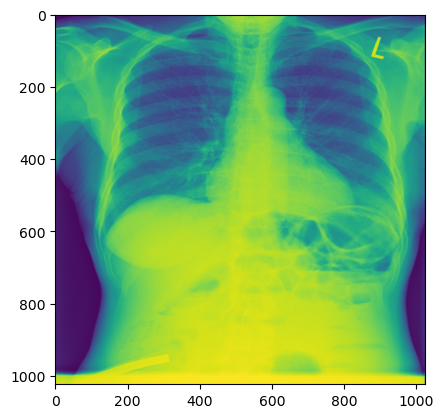

In [11]:
densenet_prediction("images/ChexNet_00007308_000.png")

Hmm...an Isopod???

## Steps 1, 2 & 3: Load DenseNet without final layers and keep weights

We can load DenseNet, this time, chopping off the final classification layers of the model. We can also specify we want to load the weights that were learned from ImageNet training.

In [12]:
# Load DenseNet121 pre-trained on imagenet, this time exclude the top (last) layer

model = keras.applications.densenet.DenseNet121(
    include_top=False, weights='imagenet')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# If you want to see the model without the last layers, uncomment and run this...
model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,062,504 (30.76 MB)

 Trainable params: 7,978,856 (30.44 MB)

 Non-trainable params: 83,648 (326.75 KB)

## Step 4: Freeze the weights

In [11]:
model.trainable = False

## Set a bunch of values for managing data and training

In [12]:
# Input image dimensions, etc.
resized_height = 224
resized_width = 224
num_channel = 3

# Paths to images. These are too large to keep in the git repo. 
# Details of getting images ready are at the end of the notebook.
base_dir = '/lustre/fs0/bsc4892/share/ChestXray-NIHCC/'
image_dir= os.path.join(base_dir, 'images_Pneumonia_labeled_subset')

## Step 5: Add new layers

In [13]:
inputs = keras.Input(shape=(resized_height, resized_width, num_channel))
x = model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)


In [14]:
# Notice that the densenet121 is compressed here and that these parameters are not trainable.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1000)           │     8,062,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,063,507 (30.76 MB)

 Trainable params: 1,003 (3.92 KB)

 Non-trainable params: 8,062,504 (30.76 MB)

In [15]:
# Compile the new model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Step 0...lots of data prep

I skipped this above, but yes, you still need to do data prep!

Even with the work that went into making the images available, there is a bunch to do still. I've added more of the details below, but a few interesting things...

First, I used scripts from [this repo](https://github.com/fatLime/Predict-Lung-Disease) to run the pre-processing that gets the image labels from a CSV file into a pickle file. 

Second, note that while we are using this for binary Pneumonia/Not-Pneumonia, there are actually 14 categories here. Also note that our "not Pneumonia" class is not "healthy"...there are a bunch of other disease states other than Pneumonia.

### Preprocess the images

```bash
[magitz@c0907a-s17 Predict-Lung-Disease]$ export PYTHONPATH=/blue/zoo4926/share/ChestXray-NIHCC/Predict-Lung-Disease/src
[magitz@c0907a-s17 Predict-Lung-Disease]$ python 000_preprocess.py                                                                 <azure_chestxray_utils.chestxray_consts object at 0x2b871942c910>
/blue/zoo4926/share/ChestXray-NIHCC/Predict-Lung-Disease/azure-share/chestxray/data/ChestX-ray8
/blue/zoo4926/share/ChestXray-NIHCC/Predict-Lung-Disease/azure-share/chestxray/output
/blue/zoo4926/share/ChestXray-NIHCC/Predict-Lung-Disease/azure-share/chestxray/data/ChestX-ray8/ChestXray-NIHCC
len of original patient id is 30805
len of cleaned patient id is 30079
len of unique patient id with annotated data 726
len of patient id with annotated data 984
first ten patient ids are [24303, 16035, 4967, 28624, 5378, 20335, 17069, 12271, 16975, 4469]
train:21563 valid:3081 test:6161
836
[('No Finding', 60361), ('Infiltration', 9547), ('Atelectasis', 4215), ('Effusion', 3955), ('Nodule', 2705), ('Pneumothorax', 2194), ('Mass', 2139), ('Effusion|Infiltration', 1603), ('Atelectasis|Infiltration', 1350), ('Consolidation', 1310), ('Atelectasis|Effusion', 1165), ('Pleural_Thickening', 1126), ('Cardiomegaly', 1093), ('Emphysema', 892), ('Infiltration|Nodule', 829), ('Atelectasis|Effusion|Infiltration', 737), ('Fibrosis', 727), ('Edema', 628), ('Cardiomegaly|Effusion', 484), ('Consolidation|Infiltration', 441)]
[('Infiltration|Cardiomegaly', 1), ('Cardiomegaly|Consolidation|Effusion|Pneumonia', 1), ('Emphysema|Infiltration|Nodule|Pleural_Thickening|Pneumothorax', 1), ('Atelectasis|Nodule|Pleural_Thickening|Pneumothorax', 1), ('Consolidation|Nodule|Pneumonia', 1), ('Atelectasis|Effusion|Emphysema|Pleural_Thickening|Pneumothorax', 1), ('Consolidation|Pneumonia|Mass', 1), ('Consolidation|Effusion|Emphysema', 1), ('Atelectasis|Hernia|Infiltration|Mass|Nodule|Pneumothorax', 1), ('Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax', 1)]
Atelectasis           11559
Cardiomegaly           2776
Consolidation          4667
Edema                  2303
Effusion              13317
Emphysema              2516
Fibrosis               1686
Hernia                  227
Infiltration          19894
Mass                   5782
No Finding            60361
Nodule                 6331
Pleural_Thickening     3385
Pneumonia              1431
Pneumothorax           5302
dtype: int64
100%|██████████████████████████████████████████████████████████████████████████████████████| 21563/21563 [00:13<00:00, 1648.38it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 3081/3081 [00:01<00:00, 1678.42it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 6161/6161 [00:05<00:00, 1221.24it/s]
train, valid, test image number is: 69217 9600 33303
<class 'dict'>
{'00024303_000.png': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8), '00016035_001.png': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8), '00016035_000.png': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8), '00004967_000.png': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8), '00004967_001.png': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)}
[magitz@c0907a-s17 Predict-Lung-Disease]$ 
```

Also, there are 1,431 X-rays where Pneumonia is detected and 110,689 where it's not. That's a lot of images to process in class. I've made a subset to make things run faster (and we still get amazing results). But the full set of images are in these folders:

Description | Path on HiPerGator
------------|-------------------
All images  | `/blue/zoo4926/share/ChestXray-NIHCC/images`
All images in Pneumonia and Not_Pneumonia sub-folders | `/blue/zoo4926/share/ChestXray-NIHCC/images_Pneumonia_labeled`
10% of the images randomly sub-sampled in labeled sub-folders | `/blue/zoo4926/share/ChestXray-NIHCC/images_Pneumonia_labeled_subset`
All images in 15 categories | `/home/magitz/blue_zoo4926/share/ChestXray-NIHCC/images_14_cat`

We'll be using the sub-sampled set. See the box above to change the path to the `image_dir` to select the full dataset.

### Let's load the data


In [16]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get full dataset (we only use the folder structure to get indices)
full_dataset = ImageFolder(root=image_dir)
num_samples = len(full_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
split = int(0.8 * num_samples)
train_indices = indices[:split]
val_indices = indices[split:]

# Create separate datasets with the desired transforms
train_dataset = Subset(ImageFolder(root=image_dir, transform=train_transform), train_indices)
val_dataset = Subset(ImageFolder(root=image_dir, transform=val_transform), val_indices)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")


Train size: 8992, Validation size: 2249


/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
# Look at size of the dataset
full_dataset

Dataset ImageFolder
    Number of datapoints: 11241
    Root location: /lustre/fs0/bsc4892/share/ChestXray-NIHCC/images_Pneumonia_labeled_subset

### Look at some of the loaded images

['Not_Pneumonia', 'Pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9254032].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


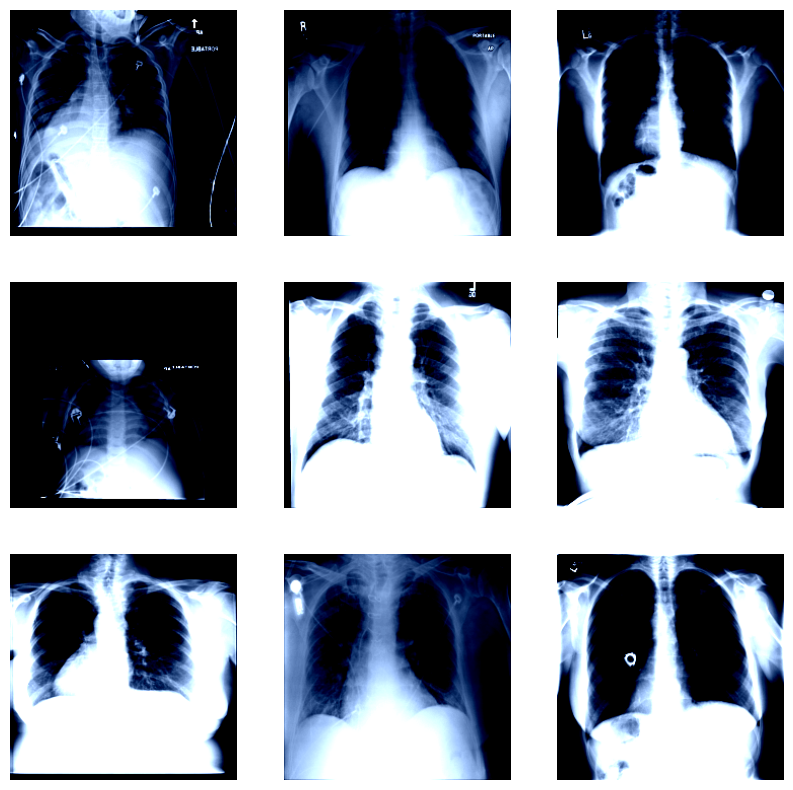

In [18]:
# Get class names from dataset
class_names = full_dataset.classes  # `classes` attribute holds class labels in ImageFolder
print(class_names)

# Get a batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Get first batch

# Plot images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())  # Convert from (C, H, W) to (H, W, C)
    plt.axis("off")
    print(images[i].shape)  # Prints shape in (C, H, W) format

## Step 6. Fit the model

In [19]:
import torch

# Custom function to convert PyTorch (NCHW) to Keras (NHWC)
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images).permute(0, 2, 3, 1)  # Convert (N, C, H, W) -> (N, H, W, C)
    labels = torch.tensor(labels)
    return images, labels

# Update DataLoader with custom collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Now, this should work:
history = model.fit(
    train_loader,
    epochs=2,
    verbose=1,
    validation_data=val_loader
)


Epoch 1/2
71/71 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8675 - loss: 0.6781 - val_accuracy: 0.9871 - val_loss: 0.6261
Epoch 2/2
71/71 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9872 - loss: 0.6075 - val_accuracy: 0.9871 - val_loss: 0.5497


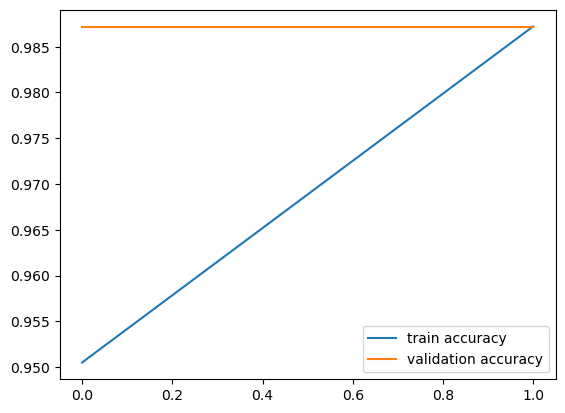

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

## Data prep stuff

The cells below were used for preparing the data. They do not need to be run for the exercise, but I left them here for you to see what was done.

### Load the pickle files

In [ ]:
# Load the labels from Pickel files generated by the 000_preprocess.py script.
# The script is part of this repo: https://github.com/fatLime/Predict-Lung-Disease
# For this class, it is located at /blue/zoo4926/share/ChestXray-NIHCC/Predict-Lung-Disease/000_preprocess.py
code_base ='Predict-Lung-Disease/'
data_partitions_dir ='azure-share/chestxray/output/data_partitions/'

label_path = os.path.join(base_dir, code_base, data_partitions_dir, 'labels14_unormalized_cleaned.pickle')

partition_path = os.path.join(base_dir, code_base, data_partitions_dir, 'partition14_unormalized_cleaned.pickle')

with open(label_path, 'rb') as f:
    labels = pickle.load(f)

with open(partition_path, 'rb') as f:
    partition = pickle.load(f)

### Process images into Pneumonia and Not_Pneumonia folders

In [ ]:
# Make folders for Pneumonia and Not_Pneumonia with the images
# Note...there is likely an easier way to do this, pulling labels
# from the pickle files or variable defines above, but...

def process_Pneumonia(labels, in_path, out_base_path):
    '''Takes a labels Pickle input and splits images into Pneumonia vs Not_Pneumonia'''
    
    pneumonia_path = os.path.join(out_base_path, 'Pneumonia')
    not_path = os.path.join(out_base_path, 'Not_Pneumonia')
    
    print(f'Processing images in {in_path}')
    print(f'Pneumonia is class 5 (index 6) in array, images with a 1 there will be put in: {pneumonia_path}')
    print(f'Everything else will go in: {not_path}') # Note this is 
    
    pneumonia_count = 0
    not_count = 0
    
    for image_info in labels.items():
        
        if int(image_info[1][6]) == 1: #If Pneumonia, need to convert numpy.uint8 to int
            shutil.copy(os.path.join(in_path, image_info[0]), os.path.join(out_base_path, 'Pneumonia', image_info[0]))
            pneumonia_count+=1
        else:
            shutil.copy(os.path.join(in_path, image_info[0]), os.path.join(out_base_path, 'Not_Pneumonia', image_info[0]))
            not_count+=1
         
    print('Done')
    print(f'Found {pneumonia_count} Pneumonia images and {not_count} non-Pneumonia images.')


In [ ]:
# Run the function above with paths for output.
img_dir = '/blue/zoo4926/share/ChestXray-NIHCC/images/'
out_dir = '/blue/zoo4926/share/ChestXray-NIHCC/images_Pneumonia_labeled'
process_Pneumonia(labels, img_dir, out_dir)

In [ ]:
labels['00000061_003.png']

### Fix image errors

Using the full dataset, there were two images that were porly formatted. These would throw the error:

 `W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG`

To fix this, I found [this post](https://stackoverflow.com/questions/22745076/libpng-warning-iccp-known-incorrect-srgb-profile) that suggested identifying the problematic images with [`pngcrush`](https://pmt.sourceforge.io/pngcrush/) and fixing them with `mogrify` from [`imagemagick`](https://imagemagick.org/index.php).

There were too many images in the main `images` folder to process all at once, so I used the folders split by diagnosis:

```bash
[magitz@c0903a-s35 pcr010813]$ for dir in `ls -d ../../share/ChestXray-NIHCC/images_14_cat/*`; do echo "Working on $dir; ./pngcrush -warn -n ${dir}/*.png; done
Working on ../../share/ChestXray-NIHCC/images_14_cat/Atelectasis
Working on ../../share/ChestXray-NIHCC/images_14_cat/Cardiomegaly
Working on ../../share/ChestXray-NIHCC/images_14_cat/Consolidation
Working on ../../share/ChestXray-NIHCC/images_14_cat/Edema
Working on ../../share/ChestXray-NIHCC/images_14_cat/Effusion
Working on ../../share/ChestXray-NIHCC/images_14_cat/Emphysema
Working on ../../share/ChestXray-NIHCC/images_14_cat/Fibrosis
Working on ../../share/ChestXray-NIHCC/images_14_cat/Hernia
Working on ../../share/ChestXray-NIHCC/images_14_cat/Infiltration
../../share/ChestXray-NIHCC/images_14_cat/Infiltration/00002846_012.png: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
Working on ../../share/ChestXray-NIHCC/images_14_cat/Mass
../../share/ChestXray-NIHCC/images_14_cat/Mass/00000004_000.png: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
Working on ../../share/ChestXray-NIHCC/images_14_cat/Nodule
../../share/ChestXray-NIHCC/images_14_cat/Nodule/00000004_000.png: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
Working on ../../share/ChestXray-NIHCC/images_14_cat/No_Finding
Working on ../../share/ChestXray-NIHCC/images_14_cat/Pleural_Thickening
Working on ../../share/ChestXray-NIHCC/images_14_cat/Pneumonia
Working on ../../share/ChestXray-NIHCC/images_14_cat/Pneumothorax
[magitz@c0903a-s35 pcr010813]$
```

So, images `00002846_012.png` and `00000004_000.png` are the culpets. Fixing them with:
   
```bash
[magitz@c0903a-s35 pcr010813]$ mogrify ../../share/ChestXray-NIHCC/images/00002846_012.png
[magitz@c0903a-s35 pcr010813]$ mogrify ../../share/ChestXray-NIHCC/images/00000004_000.png
```
Seems to have fixed things...

### Process images into 14-desease categories (plus "No_Finding")

In [ ]:
# Make folders for Pneumonia and Not_Pneumonia with the images
# Note...there is likely an easier way to do this, pulling labels
# from the pickle files or variable defines above, but...

def process_14(labels, in_path, out_base_path):
    '''Takes a labels Pickle input and splits images into 14 diesease categories'''
 
    # DISEASE_list is from: Predict-Lung-Disease/src/azure_chestxray_utils.py
    DISEASE_list = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                    'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
    disease_count = {}
    
    # Make the folders for each disease in base_out_path, setup counter
    for disease in DISEASE_list:
        os.mkdir(os.path.join(out_base_path, disease))
        disease_count[disease]=0
        
    os.mkdir(os.path.join(out_base_path, 'No_Finding')) # Make the No_finding folder
    disease_count['No_Finding']=0
        
    print(f'Processing images in {in_path}')
    
    for image_info in labels.items():
        disease_index_number = 0
        finding=0
        # Go through each disease category and check if that disease is indicated
        for disease in DISEASE_list:
            if int(image_info[1][disease_index_number]) == 1: #If disease = 1, need to convert numpy.uint8 to int
                shutil.copy(os.path.join(in_path, image_info[0]), os.path.join(out_base_path, disease, image_info[0]))
                disease_count[disease]+=1
                disease_index_number+=1 # Go to next disease index
                finding+=1
            else:
                disease_index_number+=1 # Go to next disease index
                
        if finding == 0: # If No_finding
            shutil.copy(os.path.join(in_path, image_info[0]), os.path.join(out_base_path, 'No_Finding', image_info[0]))
            disease_count['No_Finding']+=1
                
          
    print('Done')
    
    for disease in DISEASE_list:
        print(f'Disease: {disease}:\t {disease_count[disease]}')
            
    print(f"No_Finding:\t {disease_count['No_Finding']}")

In [ ]:
# Run the function above with paths for output.
img_dir = '/blue/zoo4926/share/ChestXray-NIHCC/images/'
out_dir = '/blue/zoo4926/share/ChestXray-NIHCC/images_14_cat'
process_14(labels, img_dir, out_dir)

### Randomly subsample the images to make datasets that can run in a few minutes

In [ ]:
def subset_images(in_base, out_base, fraction):
    '''Takes an input folder and for each sub folder samples 
    a fraction of the files, putting the output into corresponding 
    out_base folders'''
    
    for in_base, dirs, files in os.walk(in_base):
        for subdir in dirs:
            print(f'Working in {os.path.join(in_base, subdir)}, copying {fraction} of the files to {os.path.join(out_base, subdir)}')
            os.mkdir(os.path.join(out_base, subdir)) # Make the sub directory
            for file in os.listdir(os.path.join(in_base, subdir)):
                if random.random() < fraction:
                    shutil.copy(os.path.join(in_base, subdir, file), os.path.join(out_base, subdir, file))
                    

In [ ]:
img_dir = '/blue/zoo4926/share/ChestXray-NIHCC/images_Pneumonia_labeled'
out_dir = '/blue/zoo4926/share/ChestXray-NIHCC/images_Pneumonia_labeled_subset'
subset_images(img_dir,out_dir,0.1)

### Let's see how a simple CNN does with these data

Use the model from [17_CNNs_part2.ipynb](17_CNNs_part2.ipynb):

In [21]:
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model2 = Sequential()
model2.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(resized_height, resized_width, 3)))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding="same"))
model2.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding="same"))
model2.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding="same"))
model2.add(Flatten())
model2.add(Dense(units=512, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(units=1, activation="sigmoid"))

/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 75)   │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 75)   │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 75)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 50)   │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 50)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 50)   │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 25)     │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 25)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 19600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    10,035,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,084,000 (38.47 MB)

 Trainable params: 10,083,700 (38.47 MB)

 Non-trainable params: 300 (1.17 KB)

In [23]:
model2.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model2.fit(train_loader, batch_size=batch_size, epochs=20, verbose=1, validation_data=val_loader)

Epoch 1/20
28/71 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9055 - loss: 0.3726   

In [ ]:
def show_image(image_path):
    '''Shows the image at a given path as it is.'''
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

def load_and_scale_image(image_path):
    '''Loads and scales the image to a 28x28 greyscale image, like the training data'''
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

# Creates a dictionary to lookup what category number is what. 
# NOTE: this is based on there being 24 categories, we have 25, somehwere this will go wrong...
alphabet = "abcdefghijklmnopqrstuvwxy"
dictionary = {}
for i in range(24):
    dictionary[i] = alphabet[i]
dictionary

def predict_letter(file_path):
    '''Given an image, load it, scale for model and predict letter'''
    show_image(file_path)
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    image = image.reshape(1,28,28,1) 
    image = image/255
    prediction = model.predict(image)
    print(prediction) # print the whole prediction array, probability for each category.
    # convert prediction to letter
    predicted_letter = dictionary[np.argmax(prediction)]
    return predicted_letter